## Prepare libraries and hf token access

In this notebook, we will fine-tune [pretrained PaliGemma](https://huggingface.co/google/paligemma2-3b-pt-448) on an architecture styles dataset created by ourselves. It describes buildings in detail, their style, materials used etc. The images used are around 500x500, therefore the medium paligemma 3b version will be used (448).

In [1]:
!pip install -q -U datasets bitsandbytes peft git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.3 

We will authenticate to access the model using `hf_token` as a secret key in the notebook.

In [2]:
from google.colab import userdata
import os
from huggingface_hub import login

hf_token = userdata.get('hf_token')
os.environ["HUGGINGFACE_TOKEN"] = hf_token
login(token=hf_token)

## Dataset loading

Let's load the dataset.

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os
import json
from PIL import Image
from datasets import Dataset
import pandas as pd

# Extract
zip_path = '/content/drive/MyDrive/arch_review.zip'
extract_dir = '/content'

print("Extracting zip file...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Set paths to the extracted data
DATA_DIR = '/content/archreview'
JSON_PATH = os.path.join(DATA_DIR, 'edited_descriptions.json')
IMAGES_DIR = os.path.join(DATA_DIR, 'arch_data')

print(f"Data directory: {DATA_DIR}")
print(f"JSON file path: {JSON_PATH}")
print(f"Images directory: {IMAGES_DIR}")

# Load JSON dataset
with open(JSON_PATH, 'r') as f:
    data = json.load(f)

# Split into train and validation sets (90/10 split)
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(data, test_size=0.1, random_state=42)

print(f"Training examples: {len(train_data)}")
print(f"Validation examples: {len(val_data)}")

# Function to process the data into the format needed for HuggingFace datasets
def process_data(data_list):
    processed_data = []

    for item in data_list:
        # Get the relative path
        rel_path = item['image_path'].replace('\\', '/')

        style = "Unknown style"
        if "style" in item:
            style = item["style"]

        # Construct the full path relative to DATA_DIR
        full_path = os.path.join(DATA_DIR, rel_path)

        # Check if the file exists
        if os.path.exists(full_path):
            processed_item = {
                "image_path": full_path,
                "description": item['description'].replace("<|endoftext|>", ""),
                "style": style,
            }
            processed_data.append(processed_item)
        else:
            print(f"Warning: File not found: {full_path}")

    return processed_data

# Process the data
processed_train_data = process_data(train_data)
processed_val_data = process_data(val_data)

print(f"Processed training examples: {len(processed_train_data)}")
print(f"Processed validation examples: {len(processed_val_data)}")

# Convert to pandas dfs
train_df = pd.DataFrame(processed_train_data)
val_df = pd.DataFrame(processed_val_data)

# Function to load images
def load_image(example):
    try:
        image = Image.open(example['image_path']).convert('RGB')
        example['image'] = image
        return example
    except Exception as e:
        print(f"Error loading image {example['image_path']}: {e}")
        return None

# Create HuggingFace datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Map the dataset to load images
train_dataset = train_dataset.map(load_image, remove_columns=['image_path'])
val_dataset = val_dataset.map(load_image, remove_columns=['image_path'])

# Filter out any None entries (failed image loads)
train_dataset = train_dataset.filter(lambda example: example is not None)
val_dataset = val_dataset.filter(lambda example: example is not None)

print(f"Final training examples: {len(train_dataset)}")
print(f"Final validation examples: {len(val_dataset)}")

# Save datasets for later use if needed
train_dataset.save_to_disk('paligemma_arch_train_dataset')
val_dataset.save_to_disk('paligemma_arch_val_dataset')

print("Dataset preparation complete!")

Mounted at /content/drive
Extracting zip file...
Data directory: /content/archreview
JSON file path: /content/archreview/edited_descriptions.json
Images directory: /content/archreview/arch_data
Training examples: 700
Validation examples: 78
Processed training examples: 700
Processed validation examples: 78


Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Map:   0%|          | 0/78 [00:00<?, ? examples/s]

Filter:   0%|          | 0/700 [00:00<?, ? examples/s]

Filter:   0%|          | 0/78 [00:00<?, ? examples/s]

Final training examples: 700
Final validation examples: 78


Saving the dataset (0/1 shards):   0%|          | 0/700 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/78 [00:00<?, ? examples/s]

Dataset preparation complete!


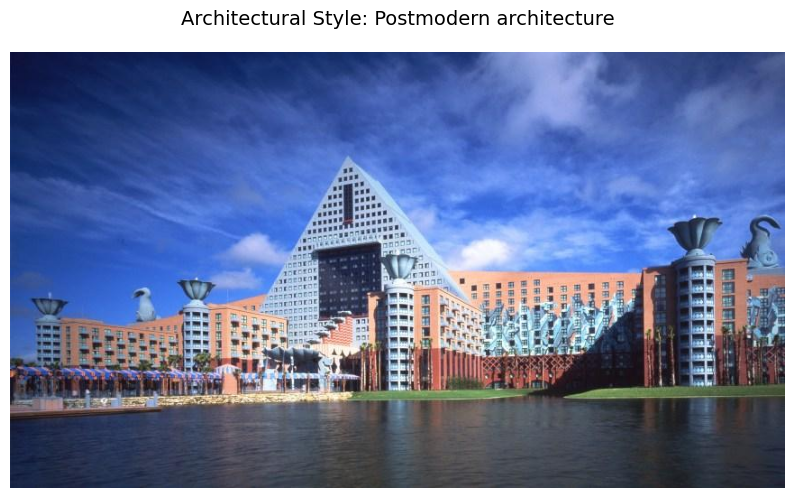

Description:
The building in the image is the Grand Floridian Resort & Spa, a luxury hotel located at Walt Disney World Resort in Florida. This architectural style is often referred to as postmodern, which is created as a response to the modernism movement some deemed lacking in character.

Key features of this style include:
- Simple but dynamic geometric forms with interesting angles.
- Prominent use of columns and pilasters.
- Use of vivid colors and fun materials.
- A combination of brick and stucco exteriors.
- Large windows for natural light.

This style is typically associated with the late 20th century, reflecting both nostalgia for classical architecture and innovation in materials and construction methods.

Materials predominantly used in this building include:
- Brick: Seen on the upper floors and certain decorative elements.
- Stucco: Used on the lower floors and exterior walls.
- Glass: In large windows throughout the structure.
- Metal: For structural supports and decorat

{'description': 'The building in the image is the Grand Floridian Resort & Spa, a luxury hotel located at Walt Disney World Resort in Florida. This architectural style is often referred to as postmodern, which is created as a response to the modernism movement some deemed lacking in character.\n\nKey features of this style include:\n- Simple but dynamic geometric forms with interesting angles.\n- Prominent use of columns and pilasters.\n- Use of vivid colors and fun materials.\n- A combination of brick and stucco exteriors.\n- Large windows for natural light.\n\nThis style is typically associated with the late 20th century, reflecting both nostalgia for classical architecture and innovation in materials and construction methods.\n\nMaterials predominantly used in this building include:\n- Brick: Seen on the upper floors and certain decorative elements.\n- Stucco: Used on the lower floors and exterior walls.\n- Glass: In large windows throughout the structure.\n- Metal: For structural s

In [4]:
from datasets import load_from_disk

def display_random_example(dataset):
    """Display a random example from the transformed HuggingFace dataset with style information."""
    import random
    import matplotlib.pyplot as plt

    random_index = random.randint(0, len(dataset) - 1)
    example = dataset[random_index]

    # Extract the style from the description or metadata
    style = "Unknown style"
    if "style" in example:
        style = example["style"]

    # Display the image
    plt.figure(figsize=(10, 8))
    plt.imshow(example["image"])
    plt.axis('off')
    plt.title(f"Architectural Style: {style}", fontsize=14, pad=20)
    plt.show()

    # Display the description
    print("Description:")
    print(example["description"])

    print(f"\nRandom example index: {random_index}")

    return example

train_dataset = load_from_disk('paligemma_arch_train_dataset')
val_dataset = load_from_disk('paligemma_arch_val_dataset')

display_random_example(train_dataset)

Our dataset is a very general one and similar to many datasets that PaliGemma was trained with. In this case, we do not need to fine-tune the image encoder, the multimodal projector but we will only fine-tune the text decoder.

In [4]:
from transformers import PaliGemmaProcessor
model_id ="google/paligemma2-3b-pt-448" # 224/448/896

In [38]:
from transformers import PaliGemmaForConditionalGeneration
import torch
from transformers import AutoConfig
config = AutoConfig.from_pretrained(model_id)
config.text_config.use_cache = False # This also pops up when starting tuning
device = "cuda"
model = PaliGemmaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    attn_implementation='eager',  # Use eager attention as recommended for Gemma2 models during tuning
).to(device)

# print(model)

# Freeze some model layers or entire components

# for param in model.vision_tower.parameters():
#     param.requires_grad = False

# for param in model.multi_modal_projector.parameters():
#     param.requires_grad = False

for name, param in model.vision_tower.named_parameters():
    # print(name)
    if "layers.26" not in name:  # Keep final layer trainable
        param.requires_grad = False


# Calculate trainable parameters
trainable_params = [p for p in model.parameters() if p.requires_grad]
print(f"Number of trainable parameters: {len(trainable_params)}")
print(f"Percentage of trainable parameters: {len(trainable_params)/len(list(model.parameters()))*100:.2f}%")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Number of trainable parameters: 306
Percentage of trainable parameters: 42.09%


Alternatively, if you want to do LoRA and QLoRA fine-tuning, you can run below cells to load the adapter either in full precision or quantized.

In [7]:
# from transformers import BitsAndBytesConfig, PaliGemmaForConditionalGeneration
# from peft import get_peft_model, LoraConfig

# bnb_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.bfloat16)

# lora_config = LoraConfig(
#     r=8,
#     target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
#     task_type="CAUSAL_LM",
# )

# model = PaliGemmaForConditionalGeneration.from_pretrained(model_id, device_map="auto")#, quantization_config=bnb_config)
# model = get_peft_model(model, lora_config)
# model.print_trainable_parameters()
# #trainable params: 11,298,816 || all params: 2,934,634,224 || trainable%: 0.38501616002417344


In [39]:
DTYPE = model.dtype
print(DTYPE)

torch.bfloat16


In [40]:
processor = PaliGemmaProcessor.from_pretrained(model_id)

In [41]:
import torch

# modify the collate_fn to work with our dataset
def collate_fn(examples):
    architecture_prompt = (
        "Describe this building's architectural style in detail. What are its key features? "
        "What period and region is this style associated with? What materials are predominantly "
        "used in this building? Describe any notable decorative elements, patterns, or ornaments. "
        "Describe the overall structure, including the shape, height, and any distinctive "
        "architectural elements like towers, domes, or facades. If the building has a name, "
        "please state it in the beginning."
    )

    # Create prompt with the architectural questions
    texts = [f"<image>{architecture_prompt}" for _ in examples]
    labels = [example['description'] for example in examples]
    images = [example['image'] for example in examples]

    tokens = processor(text=texts, images=images, suffix=labels,
                      return_tensors="pt", padding="longest", do_rescale=True)

    tokens = tokens.to(model.dtype).to(device)
    return tokens


We will now initialize the `TrainingArguments`.

In [42]:
# Set this in your environment before running your code
import os
from transformers import TrainingArguments

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
output_dir="paligemma448_arch_finetune_lowmem_freeze"

args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=5,
    remove_unused_columns=False,

    # Reduce batch size and increase gradient accumulation
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=16,  # Increase from 4 to 8

    # Memory optimization settings
    bf16=True,
    # bf16_full_eval=True,
    torch_compile=False,

    # Optimizer settings
    warmup_steps=30,
    learning_rate=2e-5,
    lr_scheduler_type="cosine",
    weight_decay=0.001,
    adam_beta2=0.999,
    optim="adamw_hf",            # adamw_8bit, adamw_hf

    # Evaluation settings - disable evaluation during training
    eval_strategy="no",       # Change from "steps" to "no"
    # eval_steps=200,

    # Checkpoint settings
    save_strategy="epoch",          # Save less frequently
    # save_steps=500,
    save_total_limit=3,             # Reduce from 3 to 2

    # Wandb specific settings
    report_to="wandb",                 # Enable wandb reporting
    run_name="paligemma448-arch-finetune-v3", # Custom name for this run
    logging_dir="./logs",              # Directory for logs
    logging_strategy="steps",
    logging_steps=10,                  # Log metrics every 10 steps
    logging_first_step=True,           # Log metrics at the first step


    # Performance settings
    dataloader_pin_memory=False,
    gradient_checkpointing=True,

    # Loading best model after training, based on metric
    # load_best_model_at_end=True,
    # metric_for_best_model="loss"
)


In [43]:
import wandb

wandb.init(
    project="paligemma-architecture-v5",  # Project name in wandb
    name="fine-tuning-run-freeze",          # Run name (can match run_name above)
    tags=["paligemma", "architecture", "vision-language"],
    notes="Fine-tuning PaliGemma on architectural images and descriptions",  # Description
    config={                           # Track hyperparameters
        "learning_rate": args.learning_rate,
        "epochs": args.num_train_epochs,
        "batch_size": args.per_device_train_batch_size * args.gradient_accumulation_steps,
        "model_name": "PaliGemma",
        "dataset_size": len(train_dataset),
        "optimizer": args.optim,
        "warmup_steps": args.warmup_steps,
        "weight_decay": args.weight_decay,
    }
)

We can now start training.

In [44]:
from transformers import Trainer

trainer = Trainer(
        model=model,
        train_dataset=train_dataset,
        # eval_dataset=val_dataset,
        data_collator=collate_fn,
        args=args
        )


LoRA with bsz of 2 works on A100 Colab. You can apply gradient accumulation (which is enabled in this notebook) to simulate larger batch sizes.
Currently there's an issue with QLoRA, we are investigating and will solve soon.

In [45]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss
1,39.234400
10,36.723700
20,27.367000
30,22.370500
40,20.286000
50,16.647700
60,14.732100
70,14.621000
80,14.768300
90,12.652400


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


TrainOutput(global_step=215, training_loss=11.728755835599678, metrics={'train_runtime': 1643.7578, 'train_samples_per_second': 2.129, 'train_steps_per_second': 0.131, 'total_flos': 7.03118908720224e+16, 'train_loss': 11.728755835599678, 'epoch': 4.8914285714285715})

In [46]:
import os

# Specify the path to your output directory
checkpoint_dir = output_dir
all_dirs = os.listdir(checkpoint_dir)

# Filter for checkpoint directories (they start with "checkpoint-")
checkpoint_dirs = sorted([d for d in all_dirs if d.startswith("checkpoint-")],
                        key=lambda x: int(x.split("-")[1]))

print(f"Available checkpoints:")
for ckpt in checkpoint_dirs:
    print(f"  - {ckpt}")

Available checkpoints:
  - checkpoint-132
  - checkpoint-176
  - checkpoint-215


In [48]:
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration
import torch
from tqdm import tqdm

checkpoint_path = os.path.join(output_dir, "checkpoint-176")
device = "cuda:0"
dtype = torch.bfloat16

model = PaliGemmaForConditionalGeneration.from_pretrained(
    checkpoint_path,
    torch_dtype=dtype,
    device_map=device,
).eval()

# Load processor - use the original processor you used during training
processor = AutoProcessor.from_pretrained("google/paligemma-3b-mix-448")

def evaluate_model(model, processor, dataset, num_samples=None):
    """Evaluate model on dataset samples with dimension fixing"""
    total_samples = len(dataset) if num_samples is None else min(num_samples, len(dataset))
    total_loss = 0
    processed_count = 0

    for idx in tqdm(range(total_samples), desc="Evaluating"):
        example = dataset[idx]

        # Prepare input - add <image> token in the prompt
        prompt = "<image> Describe this architectural design:"

        try:
            # Process input
            model_inputs = processor(
                text=prompt,
                images=example["image"],
                return_tensors="pt"
            )

            # Process target text
            target_text = example["description"]
            target_encoding = processor.tokenizer(
                target_text,
                return_tensors="pt"
            )

            # Get dimensions
            input_len = model_inputs["input_ids"].shape[1]  # Get the actual length

            # Set up labels with the same length as input_ids
            labels = torch.full(
                (1, input_len),
                -100,  # Fill with ignore index
                dtype=torch.long
            )

            # Move all to device
            for key in model_inputs:
                model_inputs[key] = model_inputs[key].to(model.device)

            # Forward pass with just model_inputs
            with torch.inference_mode():
                # Forward pass without labels first to see output dimensions
                outputs = model(**model_inputs)

                logits = outputs.logits  # Shape: [batch_size, seq_len, vocab_size]

                # Generate some target tokens for loss calculation
                # This is just for validation loss, not for actual training
                target_tokens = target_encoding.input_ids.to(model.device)

                # Calculate a simple cross-entropy loss for the first 10 tokens
                loss_fct = torch.nn.CrossEntropyLoss(ignore_index=-100)

                # Only use a portion of the logits corresponding to actual model outputs
                # where predictions would be made (not the input portion)
                # This is a simplified approach for validation only
                shift_logits = logits[:, -min(100, logits.size(1)):, :]
                shift_labels = torch.full(
                    (1, shift_logits.size(1)),
                    -100,  # mostly ignore tokens except few real ones
                    dtype=torch.long,
                    device=model.device
                )
                # Add a few real tokens for loss calculation
                min_len = min(target_tokens.size(1), 10)
                shift_labels[:, :min_len] = target_tokens[:, :min_len]

                # Calculate loss
                loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

            # Accumulate loss
            total_loss += loss.item()
            processed_count += 1

            # Free up memory
            del model_inputs, outputs, logits, loss
            torch.cuda.empty_cache()

            # Print progress
            if processed_count % 5 == 0:
                print(f"Processed {processed_count}/{total_samples}, "
                      f"Current avg loss: {total_loss/processed_count:.4f}")

        except Exception as e:
            print(f"Error processing example {idx}: {e}")
            import traceback
            traceback.print_exc()
            continue

    # Calculate final metrics
    avg_loss = total_loss / processed_count if processed_count > 0 else float("inf")
    print(f"\nEvaluation complete - Average loss: {avg_loss:.4f}")
    print(f"Successfully processed {processed_count}/{total_samples} examples")

    return {"eval_loss": avg_loss}

# Run evaluation on x samples
eval_results = evaluate_model(model, processor, val_dataset, num_samples=50)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating:  10%|█         | 5/50 [00:00<00:06,  7.33it/s]

Processed 5/50, Current avg loss: 12.5125


Evaluating:  22%|██▏       | 11/50 [00:01<00:04,  8.73it/s]

Processed 10/50, Current avg loss: 12.0750


Evaluating:  32%|███▏      | 16/50 [00:01<00:03,  8.99it/s]

Processed 15/50, Current avg loss: 12.5875


Evaluating:  42%|████▏     | 21/50 [00:02<00:03,  8.84it/s]

Processed 20/50, Current avg loss: 12.8094


Evaluating:  52%|█████▏    | 26/50 [00:03<00:02,  8.86it/s]

Processed 25/50, Current avg loss: 13.2050


Evaluating:  62%|██████▏   | 31/50 [00:03<00:02,  8.83it/s]

Processed 30/50, Current avg loss: 13.2438


Evaluating:  72%|███████▏  | 36/50 [00:04<00:01,  8.60it/s]

Processed 35/50, Current avg loss: 13.2518


Evaluating:  82%|████████▏ | 41/50 [00:04<00:00,  9.09it/s]

Processed 40/50, Current avg loss: 13.1937


Evaluating:  92%|█████████▏| 46/50 [00:05<00:00,  9.06it/s]

Processed 45/50, Current avg loss: 13.1333


Evaluating: 100%|██████████| 50/50 [00:05<00:00,  8.65it/s]

Processed 50/50, Current avg loss: 13.2812

Evaluation complete - Average loss: 13.2812
Successfully processed 50/50 examples


## Save, verify and/or run the model

In [36]:
save_directory = "/content/drive/MyDrive/paligemma_arch_model_freeze1"
os.makedirs(save_directory, exist_ok=True)

# Save the fine-tuned model
model.save_pretrained(save_directory)

# Save the processor/tokenizer
processor.save_pretrained(save_directory)

print(f"Model and processor saved to {save_directory}")

import json

# Save training arguments
with open(os.path.join(save_directory, "training_args.json"), "w") as f:
    json.dump(args.to_dict(), f, indent=2)

# Save training metrics
metrics={'train_runtime': 1641.5578, 'train_samples_per_second': 2.132, 'train_steps_per_second': 0.131, 'total_flos': 7.03118908720224e+16, 'train_loss': 17.000042458467707, 'epoch': 4.8914285714285715}
with open(os.path.join(save_directory, "training_metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

print(f"Training configuration and metrics saved to {save_directory}")

Model and processor saved to /content/drive/MyDrive/paligemma_arch_model_freeze1
Training configuration and metrics saved to /content/drive/MyDrive/paligemma_arch_model_freeze1


In [37]:
# Verify model can be loaded from saved location
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration
import torch

# Try loading the model and processor
try:
    test_processor = PaliGemmaProcessor.from_pretrained(save_directory)
    test_model = PaliGemmaForConditionalGeneration.from_pretrained(save_directory)
    print("Successfully verified model and processor can be loaded")
except Exception as e:
    print(f"Error loading model: {e}")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Successfully verified model and processor can be loaded


In [ ]:
# trainer.push_to_hub()

In [30]:
from huggingface_hub import ModelCard, ModelCardData

# Create model card metadata
card_data = ModelCardData(
    language="en",
    license="apache-2.0",
    model_name="PaliGemma for Architectural Analysis",
    base_model="google/paligemma-3b-mix-448",
    datasets=["Custom Architecture Dataset"],
    tags=["vision-language-model", "architecture", "paligemma", "multimodal"],
)


trainer.args.hub_model_id = "lmajnaric/paligemma-architecture"
trainer.push_to_hub()




model-00002-of-00002.safetensors:   0%|          | 0.00/1.07G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/lmajnaric/paligemma-architecture/commit/0bac61ec0229b378d52a846261561877ace46d9a', commit_message='End of training', commit_description='', oid='0bac61ec0229b378d52a846261561877ace46d9a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/lmajnaric/paligemma-architecture', endpoint='https://huggingface.co', repo_type='model', repo_id='lmajnaric/paligemma-architecture'), pr_revision=None, pr_num=None)

You can find steps to infer [here](https://colab.research.google.com/drive/100IQcvMvGm9y--oelbLfI__eHCoz5Ser?usp=sharing).

## Clear memory

In [22]:
# Clear GPU memory
import gc

torch.cuda.empty_cache()
gc.collect()

# Delete the model
del model
# Delete the trainer
del trainer
# Delete any other large objects
del processor

if 'train_dataset' in locals() or 'train_dataset' in globals():
    del train_dataset
if 'train_dataloader' in locals() or 'train_dataloader' in globals():
    del train_dataloader

In [23]:
# Reset the device
torch.cuda.empty_cache()
torch.cuda.synchronize()

# Move everything to CPU
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) and obj.device.type == 'cuda':
            obj.to('cpu')
    except:
        pass

# Force collection again
gc.collect()
torch.cuda.empty_cache()

/usr/local/lib/python3.11/dist-packages/torch/__init__.py:1113: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)
